## Class Activation Map 만들기

### Overview

1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?
3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?

### Import necessary libs

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load datasets

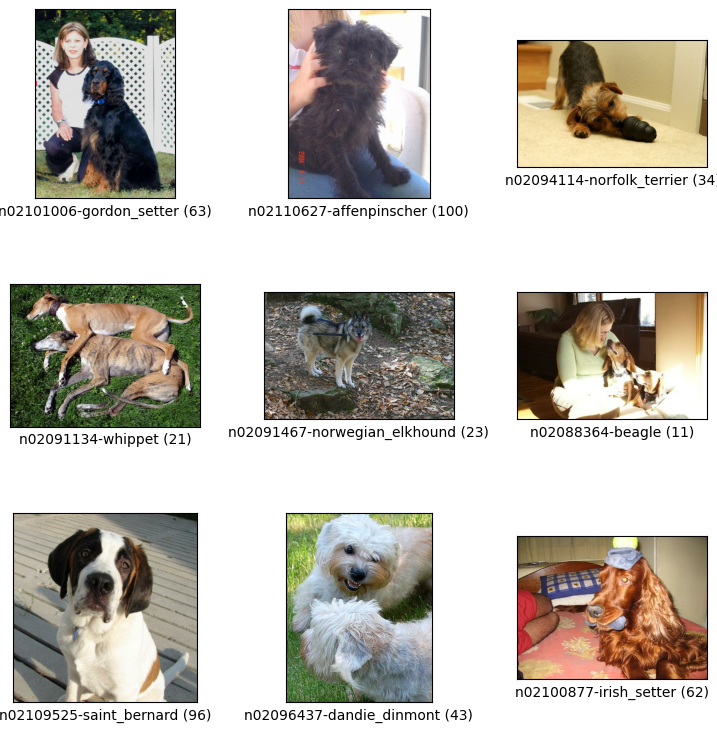

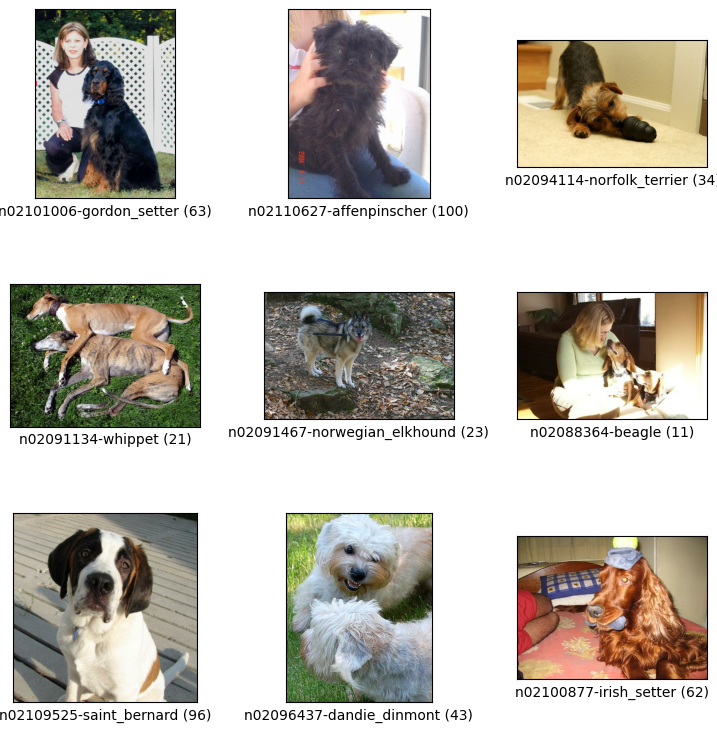

In [2]:
(ds_train, dss_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True)
tfds.show_examples(ds_train, ds_info)

In [3]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

### Implement preprocess methods

In [4]:
# 이미지 사이즈 조정
def preprocess(input):
    return tf.cast(tf.image.resize(input['image'], [224, 224]), tf.float32) / 255.0, input['label']

# preprocess 수행, 배치 생성
def apply_preprocess(ds, is_test=False, batch_size=32):
    ds = ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
    if not is_test:
        ds = ds.shuffle(buffer_size=200).repeat()
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
# 데이터 셋 생성
ds_test = apply_preprocess(dss_test, is_test=True)
ds_train = apply_preprocess(ds_train)

### Model

In [6]:
num_classes = ds_info.features["label"].num_classes

# 모델 생성
def train_model(train, test, epoch=10, batch_size=32, callbacks=None, initial_epochs=0, trained_model=None):
    if initial_epochs == 0:
        base_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
        x = base_model.output
        preds = keras.layers.Dense(num_classes, activation='softmax')(x)
        cam_model = keras.Model(inputs=base_model.input, outputs=preds)
        cam_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])
    trained_model = cam_model
    hist = trained_model.fit(
        train, initial_epoch=initial_epochs,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epoch, validation_data=test, callbacks=callbacks, verbose=1, use_multiprocessing=True)
    return trained_model, hist

윗 단계서 모델 생성시엔 sequential을 사용했지만 후에 해당 레이어에 접근할 수 없음을 깨닫고 구조를 변경했다.

원래 구문:
```python
model = keras.models.Sequential([
    keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])
```

In [11]:
model, hist_model = train_model(ds_train, ds_test,
                                callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints/", save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)])

Epoch 1/10
375/375 [==============================] - ETA: 0s - loss: 2.6044 - accuracy: 0.3910
Epoch 1: val_accuracy improved from -inf to 0.01178, saving model to checkpoints/
375/375 [==============================] - 128s 304ms/step - loss: 2.6044 - accuracy: 0.3910 - val_loss: 5.0159 - val_accuracy: 0.0118
Epoch 2/10
375/375 [==============================] - ETA: 0s - loss: 0.9033 - accuracy: 0.7548
Epoch 2: val_accuracy improved from 0.01178 to 0.24580, saving model to checkpoints/
375/375 [==============================] - 115s 308ms/step - loss: 0.9033 - accuracy: 0.7548 - val_loss: 3.0977 - val_accuracy: 0.2458
Epoch 3/10
375/375 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.9128
Epoch 3: val_accuracy improved from 0.24580 to 0.68062, saving model to checkpoints/
375/375 [==============================] - 115s 308ms/step - loss: 0.3911 - accuracy: 0.9128 - val_loss: 1.0910 - val_accuracy: 0.6806
Epoch 4/10
375/375 [==============================] - E

In [12]:
# 모델 세이빙
model.save('model')

df = pd.DataFrame(hist_model.history)
with open('model.json', mode='w') as f:
    df.to_json(f)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

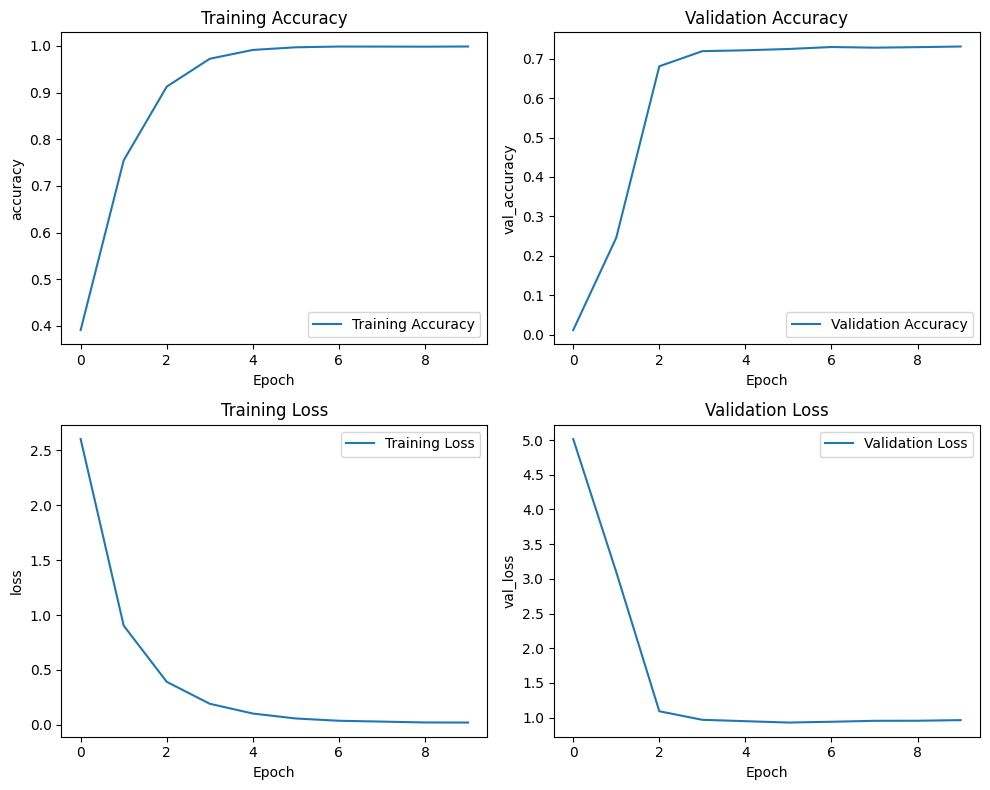

In [14]:
# 모델 train, validation 데이터 plotting
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    metrics = [('accuracy', 'Training Accuracy'), ('val_accuracy', 'Validation Accuracy'),
               ('loss', 'Training Loss'), ('val_loss', 'Validation Loss')]
    
    for ax, (metric, title) in zip(axes.flat, metrics):
        ax.plot(history.history[metric], label=title)
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(hist_model)

### CAM generation

80


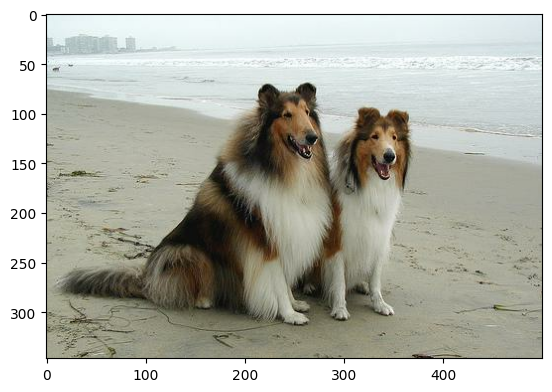

In [42]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    # bbox = sample_data[0]['objects']['bbox']
    # image = sample_data[0]['image']
    # label = sample_data[0]['label']
    return sample_data[0]

item = get_one(dss_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

get_one()에 dss_test를 argument로 넘겨야 하는데 ds_test를 넘기고 있어서 안됬었다.
1. dss_test = batch, preprocess 미적용 데이터
2. ds_test = batch, preprocess 적용 데이터

In [43]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = preprocess(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

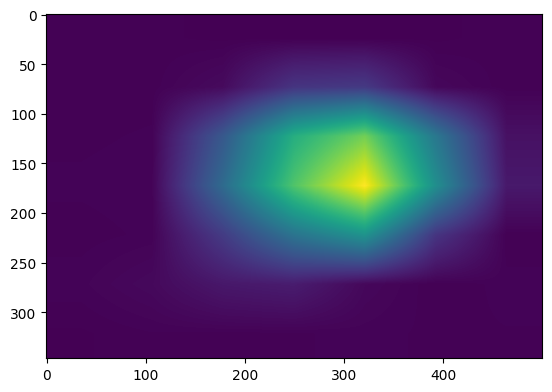

In [44]:
cam_image = generate_cam(model, item)
plt.imshow(cam_image)
plt.show()

In [45]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

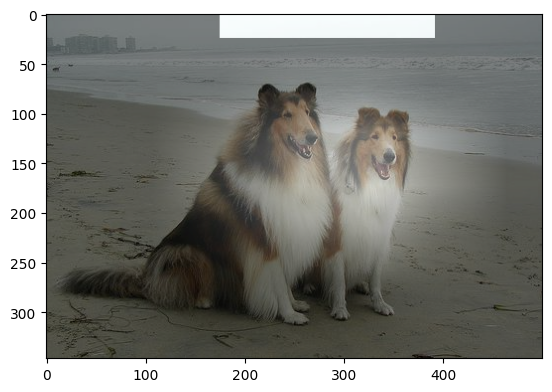

In [46]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM

67


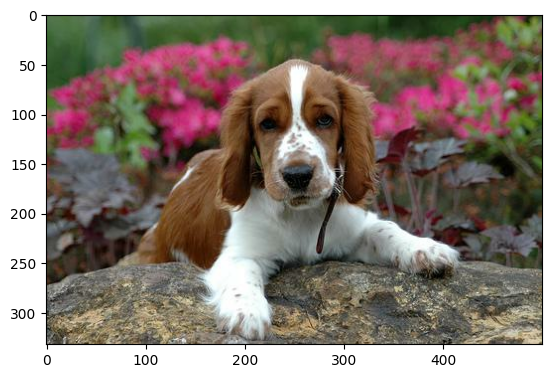

In [47]:
item = get_one(dss_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [48]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = preprocess(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

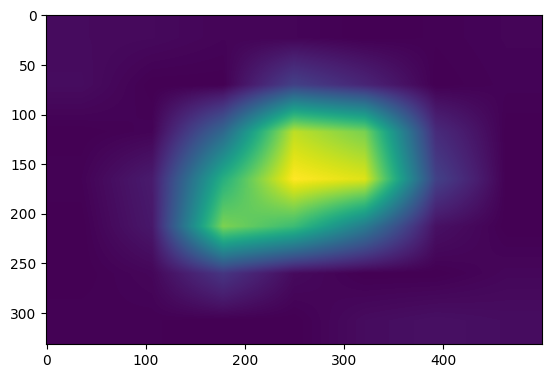

In [49]:
grad_cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

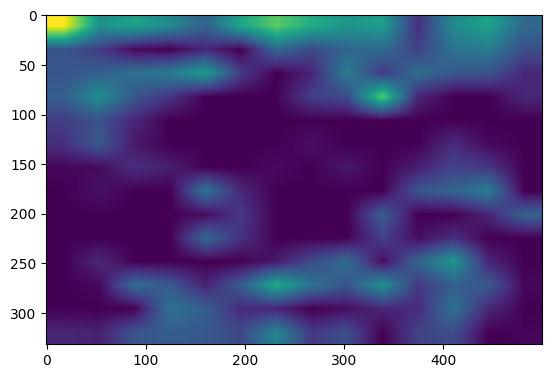

In [50]:
grad_cam_image = generate_grad_cam(model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

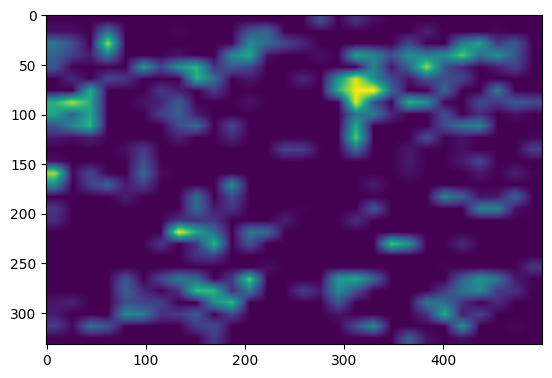

In [51]:
grad_cam_image = generate_grad_cam(model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

역시 뒷 레이어일 수록 잘 features를 잘 캐치한다. 

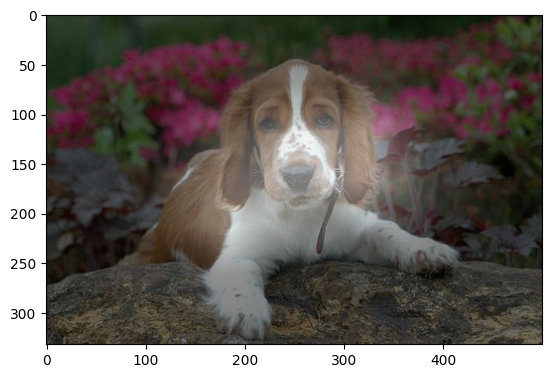

In [52]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Detection

80


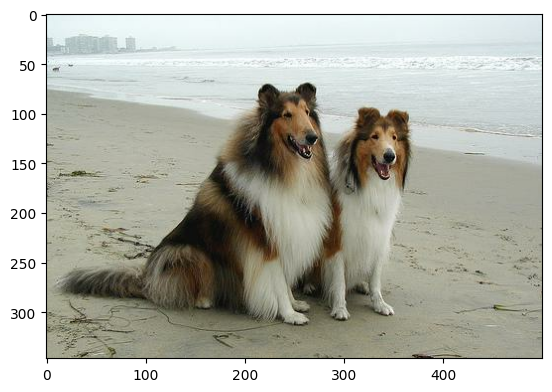

In [53]:
item = get_one(dss_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

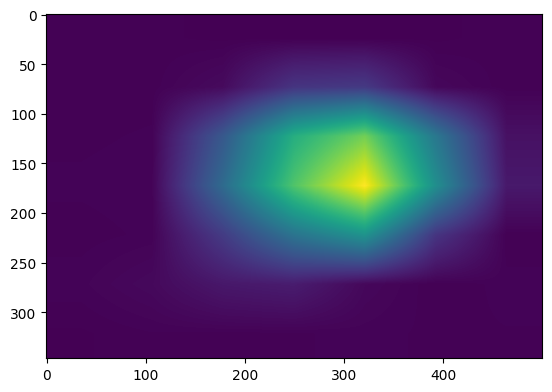

In [54]:
cam_image = generate_cam(model, item)
plt.imshow(cam_image)
plt.show()

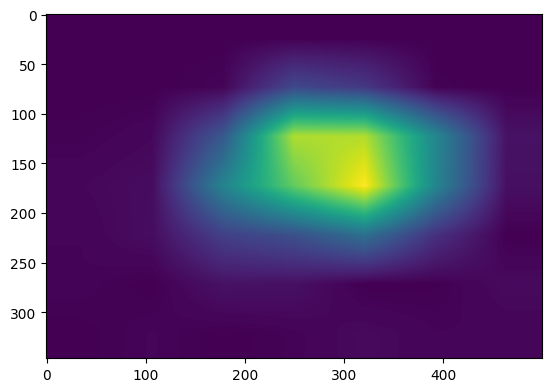

In [55]:
grad_cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [59]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [60]:
rect1 = get_bbox(cam_image)
rect2 = get_bbox(grad_cam_image)

/tmp/ipykernel_55357/770630722.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


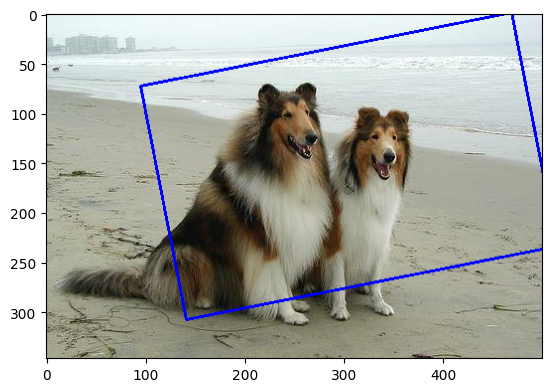

In [61]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect1], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

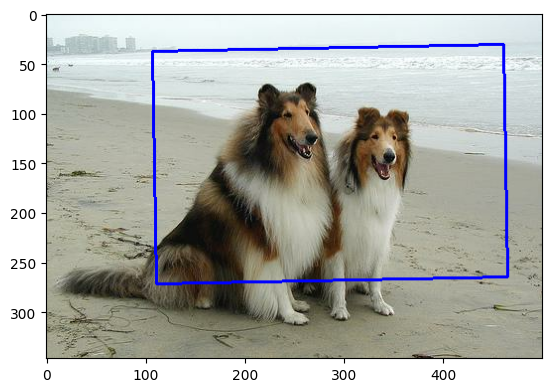

In [62]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect2], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [63]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box x_max
    ]
    return bbox

In [64]:
pred_bbox1 = rect_to_minmax(rect1, item['image'])
pred_bbox2 = rect_to_minmax(rect2, item['image'])

In [66]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [67]:
print(get_iou(pred_bbox1, item['objects']['bbox'][0]))
print(get_iou(pred_bbox2, item['objects']['bbox'][0]))

0.30661029685767666
0.31522108114047076


### Conclusion

#### 성능 비교:
1. CAM이 더 잘 나온다.
2. CAM은 박스가 조금 더 치우쳐져 있다.

#### 느낀점:
1. Direction 안보고 코드 쓰다가 ResNet 레이어 추출을 못해서 다시 학습했다. 앞으로는 혼자 쓰려고 해도 남이 다르게 한 이유를 먼저 생각해보고 쓰자.